## Load necessary modules

In [1]:
# show images inline
%matplotlib inline

# import keras
import keras

# import keras_retinanet
from keras_retinanet.models.resnet import custom_objects
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())

/home/aodev/miniconda3/envs/keras-cpu/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load RetinaNet model

This model is trained for 2 epochs on the complete Pascal VOC dataset with 4 classes.

In [6]:
# adjust this to point to your downloaded/trained model
model_path = "/home/aodev/keras-retinanet/training/Sample/GCP/snapshots/resnet50_csv_04.h5"

# load retinanet model
model = keras.models.load_model(model_path, custom_objects=custom_objects)
#print(model.summary())

# load label to names mapping for visualization purposes
labels_to_names = {0: 'bottle', 1: 'chair', 2: 'person', 3: 'sheep', 4: 'dog', 5: 'sofa', 6: 'train', 7: 'diningtable', 8: 'motorbike', 9: 'cat', 10: 'pottedplant', 11: 'tvmonitor', 12: 'bird', 13: 'car', 14: 'aeroplane', 15: 'bicycle', 16: 'boat', 17: 'bus', 18: 'horse', 19: 'cow'}

/home/aodev/miniconda3/envs/keras-cpu/lib/python3.5/site-packages/keras/models.py:274: UserWarning: Output "nms" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "nms" during training.
  sample_weight_mode=sample_weight_mode)


## Run detection on example

processing time:  27.301817655563354


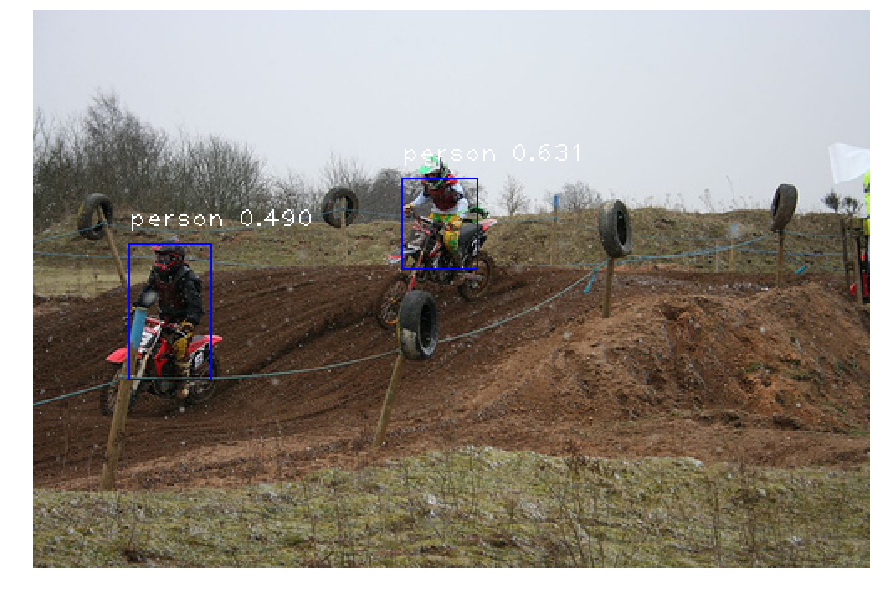

In [15]:
#image_path = "/home/aodev/keras-retinanet/examples/000000008021.jpg"
#image_path = "/home/aodev/VOCdevkit/VOC2012/JPEGImages/2009_003732.jpg"
#image_path = "/home/aodev/VOCdevkit/VOC2012/JPEGImages/2010_004361.jpg"
#image_path = "/home/aodev/VOCdevkit/VOC2012/JPEGImages/2009_005001.jpg"
#image_path = "/home/aodev/VOCdevkit/VOC2012/JPEGImages/2009_004062.jpg"
image_path = "/home/aodev/VOCdevkit/VOC2012/JPEGImages/2008_007184.jpg"

# load image
image = read_image_bgr(image_path)

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# process image
start = time.time()
_, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# compute predicted labels and scores
predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]

# correct for image scale
detections[0, :, :4] /= scale

# visualize detections
for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
    if score < 0.4:
        continue
    b = detections[0, idx, :4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 1)
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.0, (0, 0, 0), 1)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.0, (255, 255, 255), 1)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()